# 9. Unsupervised Learning Techniques

**Unsupervised Learning Tasks**
- *Clustering:* Grouping similar instances together into clusters
    - Useful for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction
- *Anomaly detection:* learn what 'normal' data looks like and use that to detect abnormal instances
    - Examples could be defective items on a production line or a new trend in a time series
- *Density estimation:* estimating the probability density function of the random process that generated the dataset
    - Used for anomaly detection - instances in low-density regions likely to be anomalies
    - Also useful for data analysis and visualisation

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams.update({"figure.figsize": [10, 8], "font.size": 15})

RANDOM_STATE = 42

import time


# useful decorator
def computation_time(func):
    def inner(*args, **kwargs):
        start = time.perf_counter()
        output = func(*args, **kwargs)
        end = time.perf_counter()
        print("Computation time: {:.1f} seconds".format(end - start))

        return output

    return inner

## Clustering

**Clustering:** Identifying similar instances and assigning them to clusters
- Similar to classification in that each instance gets assigned to a group
- Some algorithms look for instances centred around a particular point (centroid)
- Some look for continuous regions of densely pakced instances

**Applications**
- *Customer segmentation:* clustering customers based on their purchases and activity
    - Useful in recommender systems - suggest content that users in the same cluster enjoyed
- *Data analysis:* cluster a new dataset and then analyse each cluster separately
- *Dimensionality reduction*
    - Measure each instance's *affinity* with each cluster (how well it fits into the cluster)
    - Feature can be replace with vector of cluster affinities - reducing dimensions
- *Anomaly detection:* an instance with low affinity to all clusters is likely to be an anomaly
    - Particularly useful for detectinng defects in manufacturing or fraud detection
- *Semi-supervised learning:* perform clustering and propogate labels to instances in the same cluster
    - Can greatly increase the umber of labels for subsequet supervised learning
- *Search engines:* searching for images that are similar to a reference image
    - Simply cluster a database of images, assign the reference image to a cluster, and show those images in that cluster
- *Image segmentation:* clustering pixels according to their colour and replacing each pixel's colour with the mean colour of the cluster
    - Reduces number of cvolours - useful for detection and tracking as it's easier to detect contours of objects

### K-means

- Generates $k$ centroids and assigns instances to the cluster with the closest centroid
- Need to specify $k$
- Simple and can cluster quickly and efficiently in few iterations
- Doesn't behave well when the blobs have very different diameters because it only looks at distance to centroid
- *Hard clustering:* assigning each instance to a cluster
- *Soft clustering:* assign an instance a score per cluster e.g. distance or a similarity/affinity score such as using GRBFs
- Soft clustering assigns to each instance a $k$-dimensional vector, this is an efficient for non-linear dimensionality reduction 

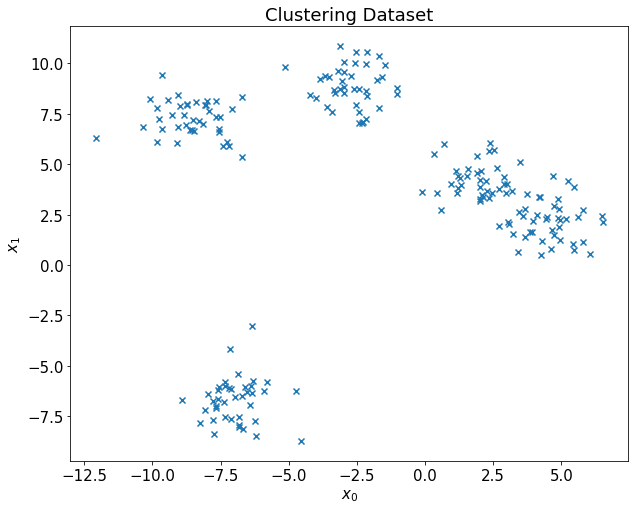

In [2]:
# generate sample data
from sklearn.datasets import make_blobs

X, _, centers = make_blobs(
    n_samples=200,
    n_features=2,
    centers=5,
    cluster_std=1,
    shuffle=True,
    random_state=RANDOM_STATE,
    return_centers=True,
)


def plot_dataset(X, y=None, ax=None, rgba_mapper=None):
    "rgba should be a function that takes values in y and outputs colors in rbga format"
    if not ax:
        fig, ax = plt.subplots()

    if not isinstance(y, np.ndarray):
        ax.scatter(X[:, 0], X[:, 1], marker="x")
    else:
        # default colors if nothing specified
        prop_cycle = plt.rcParams["axes.prop_cycle"]
        colors = prop_cycle.by_key()["color"]

        for i, cluster in enumerate(np.unique(y)):
            if rgba_mapper:
                color = rgba_mapper(cluster)
            else:
                color = colors[i]

            ax.scatter(X[y == cluster, 0], X[y == cluster, 1], marker="x", color=color)

    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")

    ax.set_title("Clustering Dataset")


plot_dataset(X)

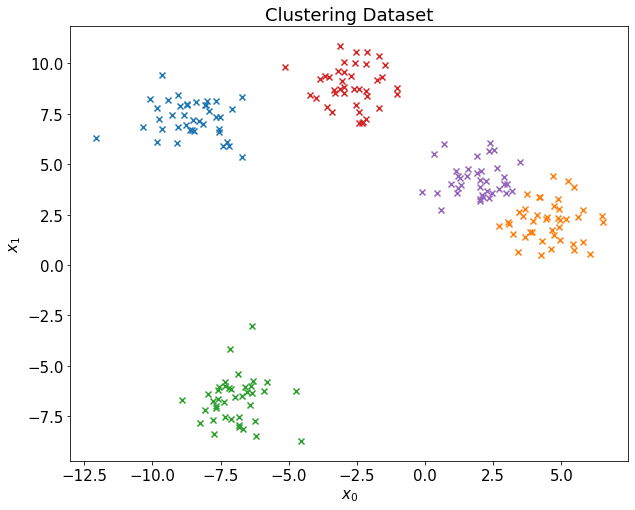

In [3]:
# clustering with kmeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
y_pred = kmeans.fit_predict(X)

plot_dataset(X, y_pred)

In [4]:
# compare detected centres with actual centres
print("Original centres:")
for i in range(centers.shape[0]):
    print("({:.1f}, {:.1f})".format(centers[i, 0], centers[i, 1]))

Original centres:
(-2.5, 9.0)
(4.6, 2.0)
(-6.9, -6.9)
(-8.8, 7.3)
(2.0, 4.2)


In [5]:
# compare detected centres with actual centres
print("K-means centres:")
for i in range(kmeans.cluster_centers_.shape[0]):
    print(
        "({:.1f}, {:.1f})".format(
            kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1]
        )
    )

K-means centres:
(-8.6, 7.3)
(4.5, 2.2)
(-7.0, -6.7)
(-2.7, 8.9)
(1.9, 4.2)


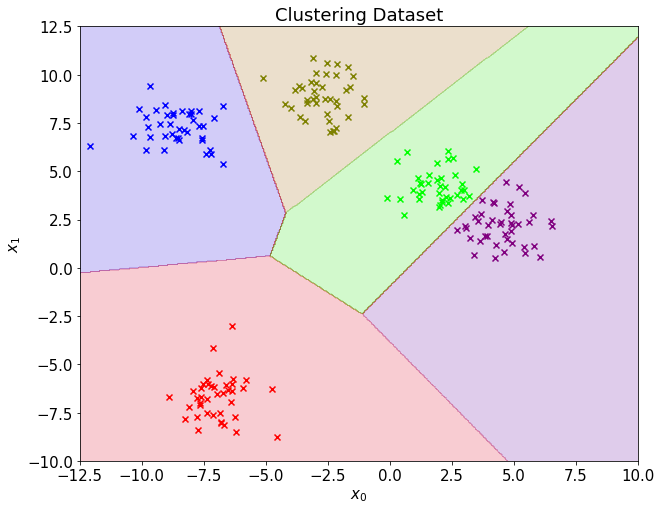

In [6]:
# plot decision boundaries
def plot_decision_boundaries(xlim, ylim, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    x0s = np.linspace(xlim[0], xlim[1], 500)
    x1s = np.linspace(ylim[0], ylim[1], 500)

    # each is a 500 x 500 array with all values of xlim/ylim repeated
    x0, x1 = np.meshgrid(x0s, x1s)

    # put in array of pairs (x0, x1) for predictions
    X = np.c_[x0.ravel(), x1.ravel()]

    y_pred = kmeans.predict(X).reshape(x0.shape)

    contours = ax.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

    return contours


xlim = (-12.5, 10)
ylim = (-10, 12.5)

fig, ax = plt.subplots()

contours = plot_decision_boundaries(xlim, ylim, ax=ax)
plot_dataset(X, y_pred, ax=ax, rgba_mapper=contours.to_rgba)

In [7]:
# transform method gives istance to centers
X_test = np.array([[-3, 0]])
kmeans.transform(X_test)

array([[9.15108442, 7.85381196, 7.7854957 , 8.88810233, 6.46461448]])

In [8]:
# define an affinity function using Gaussian RBFs
from sklearn.gaussian_process.kernels import RBF

rbf = RBF(3)  # scale parameter
rbf_affinity = lambda x: rbf.__call__(kmeans.cluster_centers_, x)
rbf_affinity(X_test)

array([[0.00953913],
       [0.03249081],
       [0.03447774],
       [0.01241564],
       [0.09810317]])

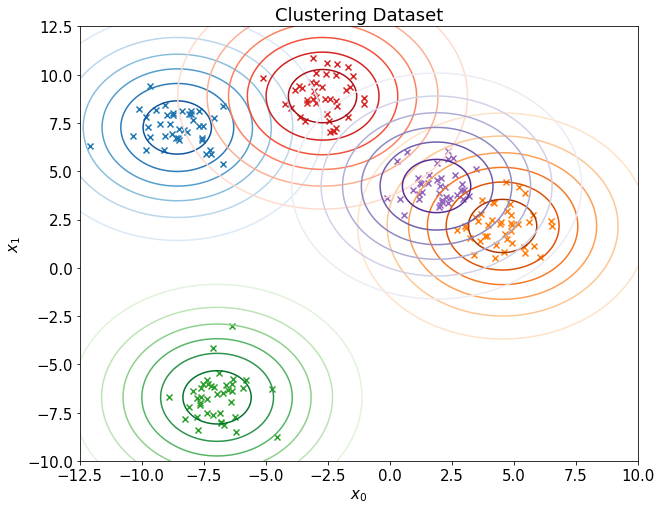

In [9]:
# plot contours for affinity
def plot_affinity(xlim, ylim, ax=None):
    if not ax:
        fig, ax = plt.subplots()

    x0s = np.linspace(xlim[0], xlim[1], 500)
    x1s = np.linspace(ylim[0], ylim[1], 500)

    # each is a 500 x 500 array with all values of xlim/ylim repeated
    x0, x1 = np.meshgrid(x0s, x1s)

    # put in array of pairs (x0, x1) for predictions
    X = np.c_[x0.ravel(), x1.ravel()]

    # y_pred = kmeans.transform(X)
    aff = rbf_affinity(X)

    cmaps = ["Blues", "Oranges", "Greens", "Reds", "Purples"]
    for cluster in range(aff.shape[0]):
        cmap = cmaps[cluster]
        ax.contour(x0, x1, aff[cluster, :].reshape(x0.shape), cmap=cmap)


xlim = (-12.5, 10)
ylim = (-10, 12.5)

fig, ax = plt.subplots()

contours = plot_affinity(xlim, ylim, ax=ax)
plot_dataset(X, y_pred, ax=ax)

**The K-Means Algorithm:**
- Algorithm:
    0. Pick $k$ centoids randomly
    1. Assign all training instances to clusters based on the closest centroid
    2. Find the centroid of each cluster - the mean of coordinates in the cluster
    3. Go back to step 1
- *Computational complexity*
    - This is guaranteed to converge in a finite number of steps - inertia can only decrease at each step
    - If the data has 'a clustering structure' the algorithm is $O(m)$, $O(n)$, and $O(k)$
    - If it doesn't the complexity can be $O(e^m)$, but this never happens in practice
- The algorithm is not guaranteed to converge to the global minimum - there are local minima

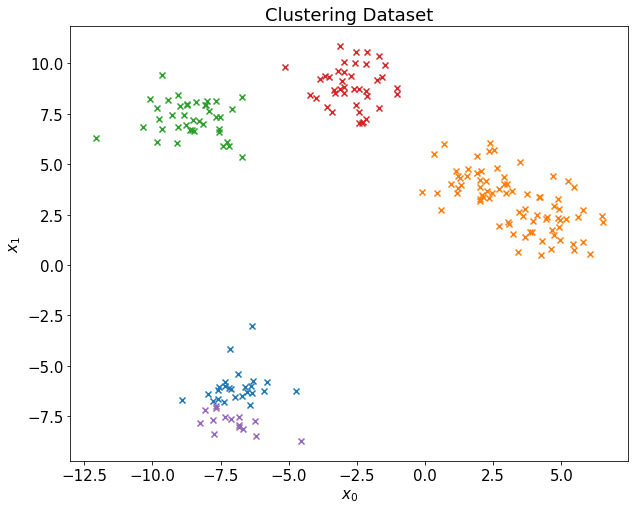

In [10]:
# suboptimal clustering of data
kmeans_sub = KMeans(n_clusters=5, init="random", n_init=1, random_state=RANDOM_STATE)
y_pred = kmeans_sub.fit_predict(X)

plot_dataset(X, y_pred)

**Centroid Initialisation Methods**
- If you know approximately where the centroids are, you can use this as an initialisation
- Alternatively, run the algorithm multiple times with different initialisation and keep the best solution
- Performance metric for fit is *inertia* - mean squared distances of training instances to centroids
- *K-Means++* adds an initilisation step that selects centroids that are far apart and less likely to converge to a suboptimal solution
    1. Randomly select first centroid $\mathbf{c}^{(1)}$ from training instances
    2. Choose new centroid $\mathbf{c}^{(i)}$ from training instances, where instance $i$ has probability $D\left(\mathbf{x}^{(i)}\right)^2 \big/ \sum_{j=1}^m D\left(\mathbf{x}^{(j)}\right)^2$ of being chosen, with $D\left(\mathbf{x}\right)^2$ the distance between $\mathbf{x}$ and the closest existing centroid. Instances far from existing centroids are much more likely to be chosen
    3. Repeat step 2 until all $k$ centroids chosen

In [11]:
# initialise with known centres
kmeans_best = KMeans(n_clusters=5, init=centers, n_init=1)
kmeans_best.fit(X)

print("Known initilisation inertia: {:.1f}".format(kmeans_best.inertia_))
print("One random initilisation inertia: {:.1f}".format(kmeans_sub.inertia_))
print("10 initilisations inertia: {:.1f}".format(kmeans.inertia_))

Known initilisation inertia: 350.6
One random initilisation inertia: 548.2
10 initilisations inertia: 350.6


**Accelerated K-Means and Mini-Batch K-Means**
- *Accelerated K-Means:* exploits the traingle inequality to reduce the number of distance calculations needed and speed up the algorithm
    - `KMeans` uses this by default
- *Mini-Batch K-Means:* uses mini-batches at each iteration rather than the whole dataset
    - Speeds up algorithm by factor of 3-4, but solutions have slightly worse interia - becomes more significant as $k$ increases
    - Allows you to cluster huge datasets that don't fit in memory (either using `memmap` or creating mini-batches and using `partial_fit()`)

In [12]:
from sklearn.cluster import MiniBatchKMeans

mb_kmeans = MiniBatchKMeans(n_clusters=5)
mb_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

**Finding the Optimal Number of Clusters**
- Higher $k$ will always mean lower inertia (you could always have an empty cluster)
- One way to select $k$ is to plot inertia against $k$ and look for the 'elbow' where adding additional clusters doesn't make much difference to inertia
- A more precise way is to plot *silhouette score* (mean *silhouette coefficient* over training instances) against $k$
- The silhouette coefficient for an instance is $(b-a)/\max(a, b)\in[-1,1]$, where $a$ is the mean distance to the training instances in the cluster and $b$ is the smallest value of this over other clusters
    - This is close to 1 if the instance is much closer to its own cluster instances than others
    - Close to 0 if it is near the boundary of its cluster
    - Close to -1 if it has been assigned to the wrong cluster
- Even more information is a silhouette diagram which plots the silhouette coefficient for each training instance, grouped by cluster, with the silhouette score
- Comparing silhouette diagrams helps compare - you may want to avoid over/undersized clusters and underperforming clusters
- Can plot silhouette diagrams using `Yellowbrick` - a machine learning visualisation package

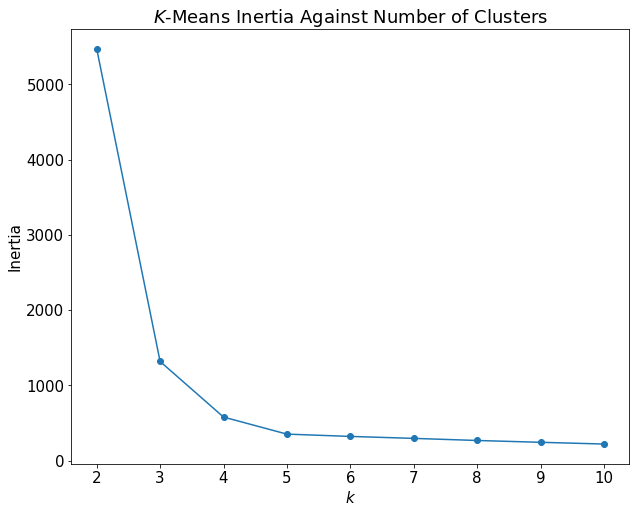

In [13]:
# fit kmeans for different values of k
kmeans_list = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    kmeans.fit(X)
    kmeans_list.append(kmeans)


def plot_interia_against_clusters(kmeans_list):
    fig, ax = plt.subplots()

    n_clusters = [kmeans.n_clusters for kmeans in kmeans_list]
    inertia = [kmeans.inertia_ for kmeans in kmeans_list]

    ax.plot(n_clusters, inertia, marker="o")

    ax.set_xlabel("$k$")
    ax.set_ylabel("Inertia")

    ax.set_title("$K$-Means Inertia Against Number of Clusters")


plot_interia_against_clusters(kmeans_list)

Looks like 4 or 5 clusters would be optimal

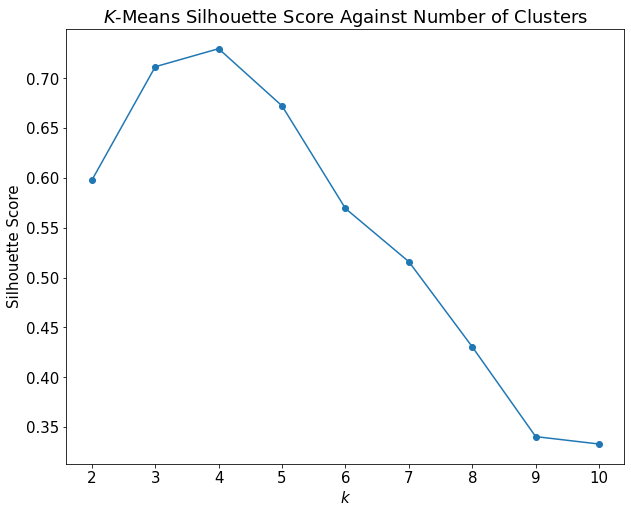

In [14]:
from sklearn.metrics import silhouette_score


def plot_silhouette_scores(kmeans_list, X):
    fig, ax = plt.subplots()

    n_clusters = [kmeans.n_clusters for kmeans in kmeans_list]
    silhouette = [silhouette_score(X, kmeans.labels_) for kmeans in kmeans_list]

    ax.plot(n_clusters, silhouette, marker="o")

    ax.set_xlabel("$k$")
    ax.set_ylabel("Silhouette Score")

    ax.set_title("$K$-Means Silhouette Score Against Number of Clusters")


plot_silhouette_scores(kmeans_list, X)

Shows that $k=3, 4, 5$ are much better than other options

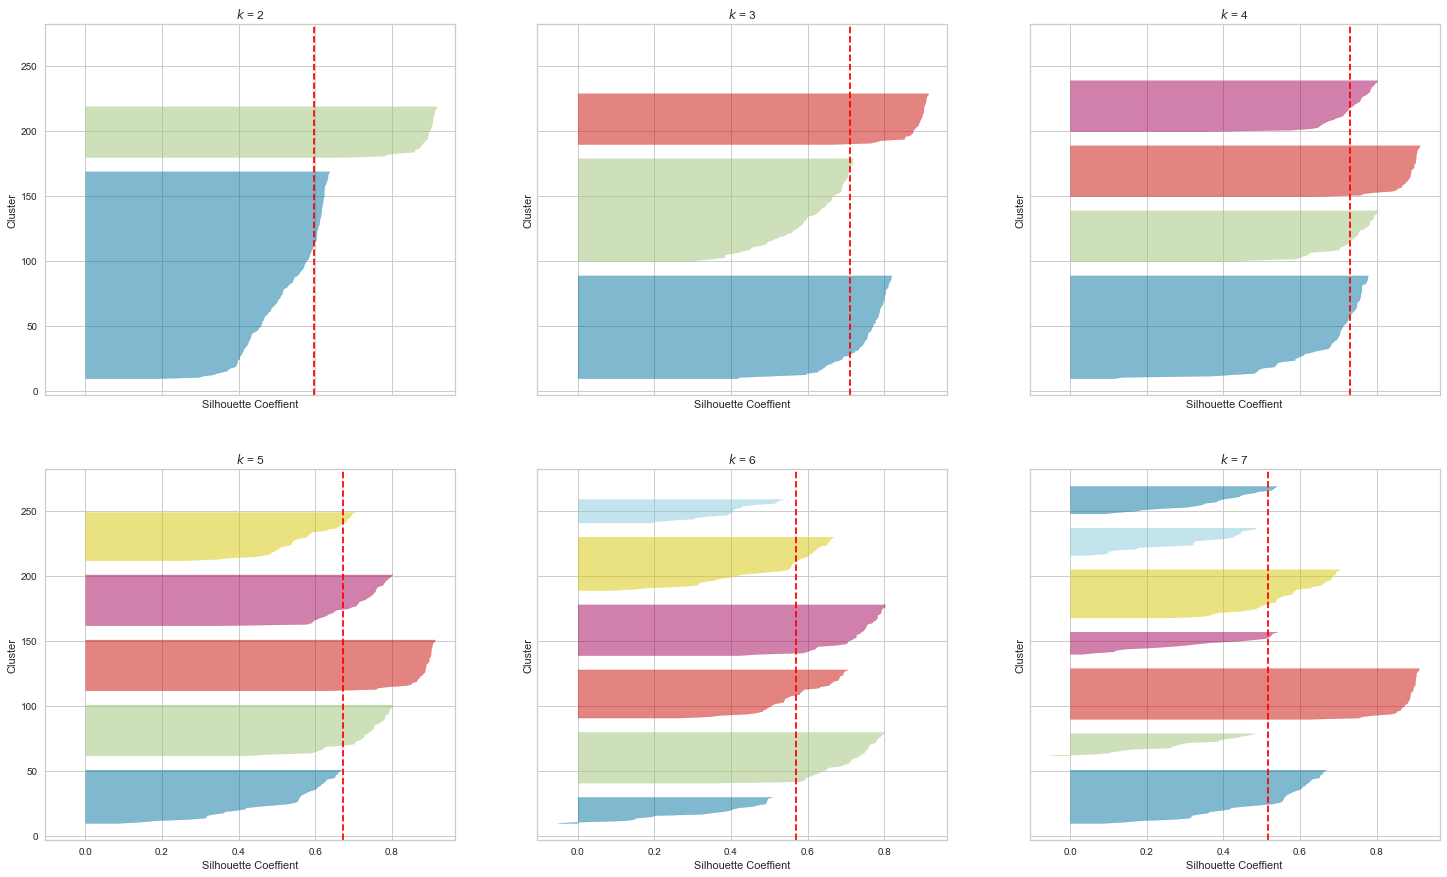

In [15]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, axs = plt.subplots(2, 3, figsize=(25, 15), sharex=True, sharey=True)
axs_ravel = axs.ravel()

for i, kmeans in enumerate(kmeans_list[:6]):
    ax = axs_ravel[i]
    visualizer = SilhouetteVisualizer(kmeans, ax=ax, colors="yellowbrick")
    visualizer.fit(X)

    ax.set_title("$k$ = {}".format(kmeans.n_clusters))

    ax.set_xlabel("Silhouette Coeffient")
    ax.set_ylabel("Cluster")

Clearly $k=2, 6, 7$ do not perform well. $k=3$ does look pretty good. $k=4$ does have the advantage that clusters are approximately the same size.

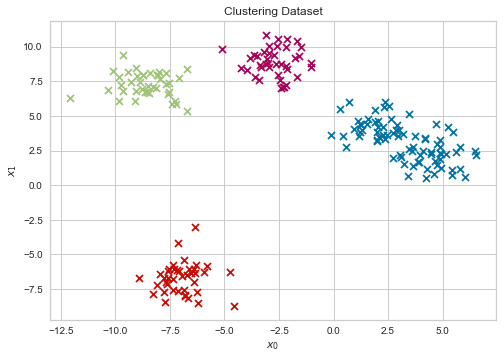

In [16]:
# clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)
y_pred = kmeans.fit_predict(X)

plot_dataset(X, y_pred)

In [17]:
# importing yellowbrick changes default matplotlib style - see https://github.com/DistrictDataLabs/yellowbrick/issues/734
# this resets defaults
from yellowbrick.style import reset_defaults

reset_defaults()

**Limits of K-Means**
- K-means is fast and scalable, but performs badly when clusters have varying sizes, different densities, or non-spherical shapes
- Also you need to select $k$
- You need to scale input features for K-means or clusters will be stretched (this won't resolve all problems though)

### Using Clustering for Image Segmentation

**Image segmentation:** partitioning an image into multiple segments
- *Semantic segmentation:* all pixels that are part of the same object type are assigned to the same segment, e.g. all pedestrians in self-driving car's vision system
- *Instance segmentationn:* all pxels that are part of the same individual object are assigned to the same segment
- *Colour segmentation:* assign pixels to the same segment if they have a similar colour, e.g. detecting forest area in satellite images
- We perform colour segmentation by using different pixels as different instances, clustering based on colour (3 features RGB), and replacing each pixel's colour with the colour of its cluster's centroid

In [18]:
import os

# paths
ROOT_DIR = "."
IMAGES_DIR = os.path.join(ROOT_DIR, "images")

os.makedirs(IMAGES_DIR, exist_ok=True)


def image_path(file_name):
    return os.path.join("images", file_name)


# url to download iamge from
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
LADYBUG_URL = os.path.join(
    DOWNLOAD_ROOT, "images", "unsupervised_learning", "ladybug.png"
)

LADYBUG_PNG = "ladybug.png"

(533, 800, 3)

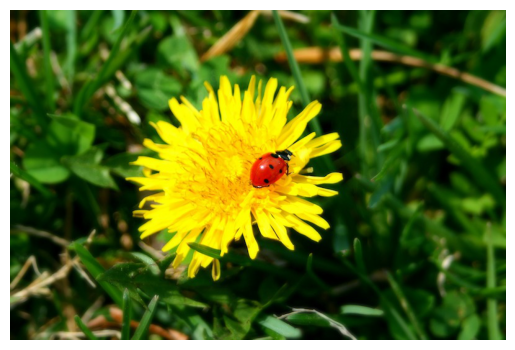

In [19]:
from urllib.request import urlretrieve

from matplotlib.image import imread


# download image from url
def fetch_image(ladybug_url=LADYBUG_URL, file_name=LADYBUG_PNG):
    urlretrieve(ladybug_url, image_path(file_name))
    image = imread(image_path(file_name))

    return image


def plot_image(image, ax=None, title=None):
    if not ax:
        fig, ax = plt.subplots()

    ax.imshow(image)
    ax.axis("off")

    ax.set_title(title)


image = fetch_image()
plot_image(image)
image.shape

In [20]:
k_val = [10, 8, 6, 4, 2]
images_seg = []

for k in k_val:
    # reshape to form (n_sample, n_feat)
    X = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X)

    # replace each instance with cluster mean
    image_seg = kmeans.cluster_centers_[kmeans.labels_, :]
    image_seg = image_seg.reshape(image.shape)

    images_seg.append(image_seg)

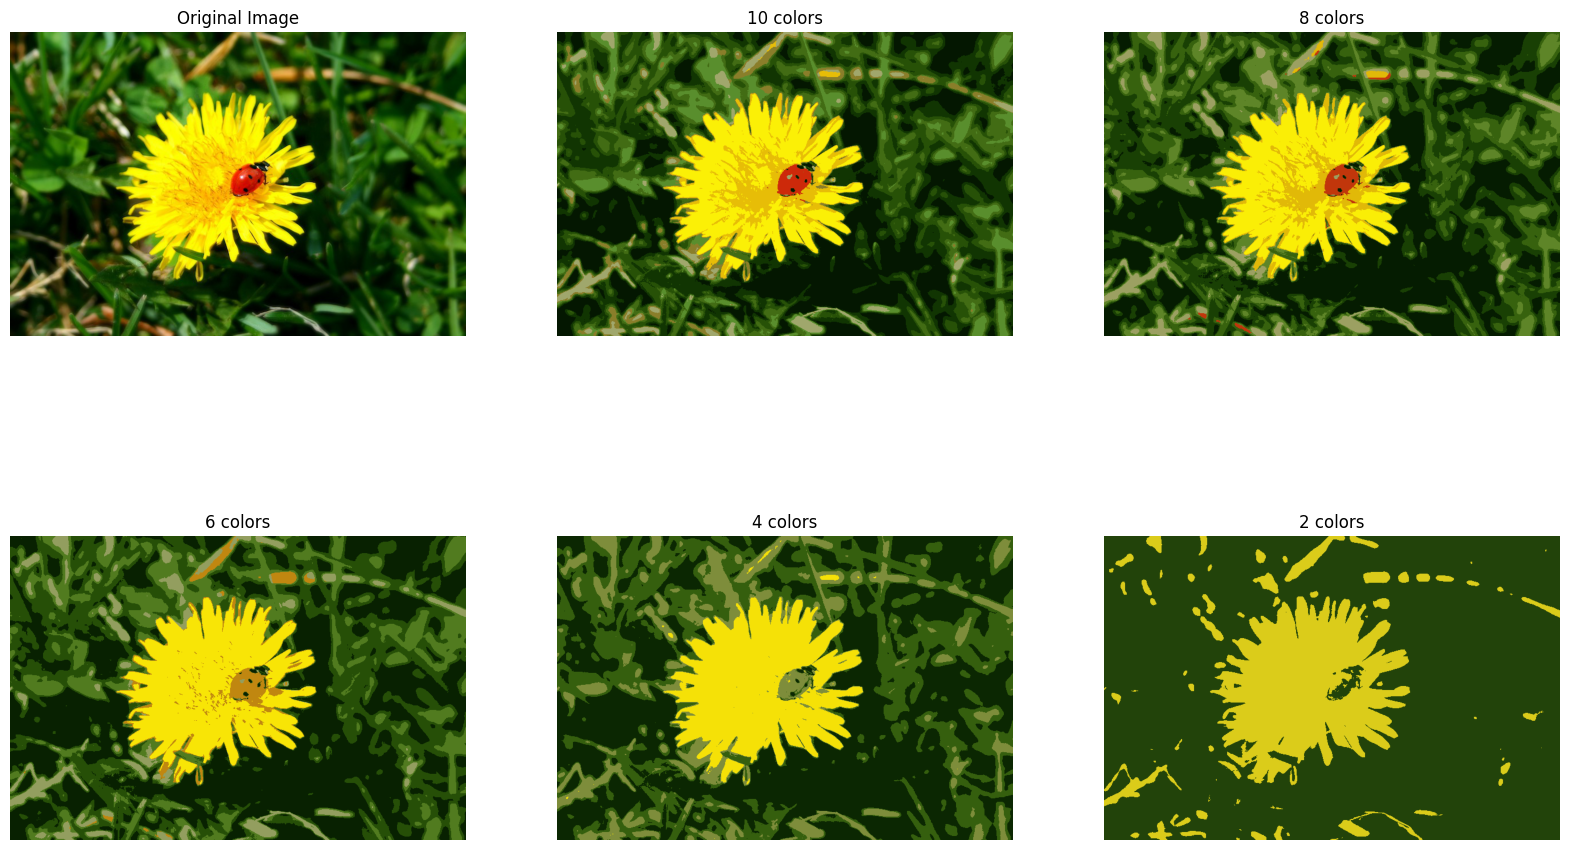

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs_ravel = axs.ravel()

plot_image(image, ax=axs_ravel[0], title="Original Image")

for i, image_seg in enumerate(images_seg):
    k = k_val[i]
    title = str(k) + " colors"

    plot_image(image_seg, ax=axs_ravel[i + 1], title=title)

### Using Clustering for Preprocessing

- Clustering can perform quick dimensionality reduction - simply cluster the training data and then replace points with the distance to the centroids
- The number of clusters can be treated as a hyperparameter and optimised using cross validation

In [22]:
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# load data
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# simple logistic regression model - default solver doesn't converge for some reason
log_reg = LogisticRegression(solver="liblinear")
log_reg.fit(X_train, y_train)

# score = mean accuracy
score = log_reg.score(X_test, y_test)
print("Logistic Regression Test Accuracy: {:.3f}".format(score))

Logistic Regression Test Accuracy: 0.961


Now let's try it with a clustering preprocessing step

In [23]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        ("kmeans", KMeans(n_clusters=50)),
        ("log_reg", LogisticRegression(solver="liblinear")),
    ]
)
pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print("Clustering + Logistic Regression Test Accuracy: {:.3f}".format(score))

Clustering + Logistic Regression Test Accuracy: 0.978


Optimise `n_clusters` hyperparameter using grid search

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {"kmeans__n_clusters": range(2, 201)}

grid_search = GridSearchCV(
    pipe, param_grid, scoring="accuracy", refit=True, cv=5, return_train_score=True
)


@computation_time
def fit_grid_search(grid_search, X, y):
    grid_search.fit(X, y)

    return grid_search


def get_cv_summary(grid_search):
    cv_results = grid_search.cv_results_

    cv_summary = pd.DataFrame(cv_results["params"])
    cv_summary["mean_test_score"] = cv_results["mean_test_score"].round(3)
    cv_summary["mean_train_score"] = cv_results["mean_train_score"].round(3)
    cv_summary = cv_summary.sort_values(
        by="mean_test_score", ascending=False
    ).reset_index(drop=True)

    return cv_summary


# grid_search = fit_grid_search(grid_search, X_train, y_train)
# pipe_best = grid_search.best_estimator_

# cv_summary = get_cv_summary(grid_search)
# cv_summary.head(20)

# grid search takes 10-15 minutes to run - this is the best estimator
pipe_best = pipe.set_params(kmeans__n_clusters=159)
pipe_best.fit(X_train, y_train);

In [25]:
score = pipe_best.score(X_test, y_test)
print("Optimised Clustering + Logistic Regression Test Accuracy: {:.3f}".format(score))

Optimised Clustering + Logistic Regression Test Accuracy: 0.978


### Using Clustering for Semi-Supervised Learning

- We may only be able to label some of our instances. Instead of choosing them at random, it would be better to choose good representatives
- After clustering, the *representative instances* are the $k$ training instances that are closest to each of the $k$ centroids
- If we can only label $k$ instances, it may be better to representative instances
- We can then either train a classification model on the labelled representatives, or propagate those labels to the remaining unlabelled instances based on their cluster and train on the whole set
- Propagating to the whole training set means that we propagate to a lot of 'questionable' instances on the boundaries. It may be better to propagate to only, say, the 20% of training instances that are closest to their centroids (the percentage can be set via cross validation)
- *Note:* this is very sensitive to the data as a very small change in the data could change the representative insstances

In [26]:
# suppose we only have resources to train 50 labelled instances
n_labelled = 50
log_reg = LogisticRegression(solver="liblinear")
log_reg.fit(X_train[:n_labelled, :], y_train[:n_labelled])

score = log_reg.score(X_test, y_test)
print("Partially Labelled Logistic Regression Test Accuracy: {:.3f}".format(score))

Partially Labelled Logistic Regression Test Accuracy: 0.817


In [27]:
# we could do better if we made 50 clusters and chose to label the instances closest to the centroids
kmeans = KMeans(n_clusters=n_labelled, random_state=RANDOM_STATE)
X_dist = kmeans.fit_transform(X_train)  # distances to centroids

# indexes of representatives for each cluster
rep_ixs = np.argmin(X_dist, axis=0)

# actual representative instances, e.g. y_rep[0] is label for representative for cluster 0
X_rep = X_train[rep_ixs, :]
y_rep = y_train[rep_ixs]

# now imagine we labelled these
log_reg = LogisticRegression(solver="liblinear")
log_reg.fit(X_rep, y_rep)

score = log_reg.score(X_test, y_test)
print("Representative Labelled Logistic Regression Test Accuracy: {:.3f}".format(score))

Representative Labelled Logistic Regression Test Accuracy: 0.914


In [28]:
# propagate labels of representatives
y_prop = y_rep[kmeans.labels_]

# now train log reg on these propagated labels
log_reg = LogisticRegression(solver="liblinear")
log_reg.fit(X_train, y_prop)

score = log_reg.score(X_test, y_test)
print(
    "Representative Propagated Logistic Regression Test Accuracy: {:.3f}".format(score)
)

Representative Propagated Logistic Regression Test Accuracy: 0.917


Actually a drop in accuracy. Better to only propagate labels to those instances we're reasonably sure of - say top 40% in closeness to centroids.

In [29]:
percentile_cutoff = 20
n_cutoff = int(X_train.shape[0] * percentile_cutoff / 100)

# distances to closest centroid
y_dist = np.min(X_dist, axis=1)

# indexes of n_cutoff instances with smallest distances to centroids
idx = np.argpartition(
    y_dist, n_cutoff
)  # all indexes, but partially ordered so first n_cutoff are those with smallest distances
idx_red = idx[:n_cutoff]

# now restrict to these indices to train
X_red = X_train[idx_red, :]
y_prop_red = y_prop[idx_red]

log_reg = LogisticRegression(solver="liblinear")
log_reg.fit(X_red, y_prop_red)

score = log_reg.score(X_test, y_test)
print(
    "Representative Propagated Logistic Regression Test Accuracy: {:.3f}".format(score)
)

Representative Propagated Logistic Regression Test Accuracy: 0.867


Could optimise this by creating a custom estimator that performs this with `percentile_cutoff` as a hyperparameter.

In [31]:
from sklearn.base import BaseEstimator


class KMeansPartiallyLabelled(BaseEstimator):
    def __init__(
        self, base_estimator, n_labelled=50, propagation_perc=None, random_state=None
    ):
        self.base_estimator = base_estimator
        self.n_labelled = n_labelled
        self.propagation_perc = propagation_perc
        self.random_state = random_state

    def fit(self, X, y):
        kmeans = KMeans(n_clusters=self.n_labelled, random_state=self.random_state)
        X_dist = kmeans.fit_transform(X)  # distances to centroids

        # representative instances
        rep_ixs = np.argmin(X_dist, axis=0)
        y_rep = y[rep_ixs]  # representative label for each cluster

        # propagate labels from representatives
        y_prop = y_rep[kmeans.labels_]

        if self.propagation_perc:
            # now restrict to training instances sufficiently close to their centroids
            propagation_cutoff = int(X.shape[0] * self.propagation_perc / 100)

            # distances to closest centroid
            y_dist = np.min(X_dist, axis=1)

            # indexes of instances sufficiently close
            idx = np.argpartition(y_dist, propagation_cutoff)
            idx_red = idx[:propagation_cutoff]

            # now restrict to these indices to train
            X_red = X[idx_red, :]
            y_prop_red = y_prop[idx_red]

            self.base_estimator.fit(X_red, y_prop_red)
        else:
            self.base_estimator.fit(X, y_prop)

        return self

    def predict(self, X):
        return self.base_estimator.predict(X)

In [34]:
# now test different hyperparameters
base_estimator = LogisticRegression(solver="liblinear")
kmeans_partial = KMeansPartiallyLabelled(
    base_estimator=base_estimator, random_state=RANDOM_STATE
)

param_grid = {
    "propagation_perc": [None] + list(range(5, 100, 5)),
    "n_labelled": [40, 45, 50]
}

grid_search = GridSearchCV(
    kmeans_partial,
    param_grid,
    scoring="accuracy",
    refit=True,
    cv=5,
    return_train_score=True,
)

grid_search = fit_grid_search(grid_search, X_train, y_train)
cv_summary = get_cv_summary(grid_search)
cv_summary.head(20)

Computation time: 87.6 seconds


,n_labelled,propagation_perc,mean_test_score,mean_train_score
0,50,90.0,0.933,0.948
1,50,85.0,0.928,0.945
2,50,95.0,0.927,0.948
3,50,80.0,0.927,0.943
4,50,NaN,0.926,0.950
5,50,75.0,0.926,0.934
6,45,NaN,0.924,0.939
7,45,95.0,0.922,0.935
8,50,45.0,0.919,0.924
9,40,55.0,0.919,0.925


Unsurprisingly performance generally increases if we label more training instances.

In [35]:
# now test performance
kmeans_partial = grid_search.best_estimator_
y_pred = kmeans_partial.predict(X_test)
score = np.mean(y_pred == y_test)
print(
    "Optimised Representative Propagated Logistic Regression Test Accuracy: {:.3f}".format(
        score
    )
)

Optimised Representative Propagated Logistic Regression Test Accuracy: 0.919


**Active Learning:** when a human provides labels for specific instances whenn the algorithm requests them to improve performance
- *Uncertainty sampling:* a common strategy for active learning
    1. Model is trained on all currently labelled instances
    2. Requests labels for instances with lowest estimated probabilities
    3. Continue until performance improvement stops being for the labelling effort
- Other strategies: label instances...
    - ...that would result in largest model changes
    - ...that would result in largest drop in validation error
    - ...that different models disagree on (e.g. SVM vs random forest)